# Fine-Tuning BERT on GLUE - MNLI

From [GLUE: A Multi-Task Benchmark and Analysis Platform for Natural Language Understanding - Wang et al.](https://arxiv.org/pdf/1804.07461):

The Multi-Genre Natural Language Inference Corpus (Williams et al., 2018) is a crowdsourced collection of sentence pairs with textual entailment annotations. Given a premise sentence
and a hypothesis sentence, the task is to predict whether the premise entails the hypothesis (entailment), contradicts the hypothesis (contradiction), or neither (neutral). The premise sentences are
gathered from ten different sources, including transcribed speech, fiction, and government reports.
We use the standard test set, for which we obtained private labels from the authors, and evaluate
on both the matched (in-domain) and mismatched (cross-domain) sections. We also use and recommend the SNLI corpus (Bowman et al., 2015) as 550k examples of auxiliary training data.

## Configuration

In [1]:
import os

# Where to store the huggingface data. On the provided Jupyterlab instance that should be within the shared group folder.
os.environ['HF_HOME'] = '../groups/192.039-2024W/bert/huggingface/cache'

In [2]:
from pathlib import Path

from transformers import set_seed

# RANDOMNESS SEED
SEED = 42
set_seed(SEED)

# Which dataset to load
DATASET_NAME = "glue"
DATASET_TASK = "mnli"

PRE_TRAINED_CHECKPOINT = "google-bert/bert-base-uncased"

TRAIN_OUTPUT_DIR = (
    Path("../groups/192.039-2024W/bert") / "training" / f"{DATASET_NAME}-{DATASET_TASK}"
)

BATCH_SIZE = 32  # Original Paper claims to use 32 for GLUE tasks
NUM_EPOCHS = 5  # Original Paper claims to use 3 fine-tuning epochs for GLUE tasks

In [3]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  device_count = torch.cuda.device_count()
  device_name = torch.cuda.get_device_name(0)

  print(f"There are {device_count} GPU(s) available.")
  print(f"GPU used: {device_name}")
  ! nvidia-smi -q --display=MEMORY,COMPUTE

else:
  print("No GPU available, using CPU.")
  device = torch.device("cpu")

There are 1 GPU(s) available.
GPU used: NVIDIA GeForce RTX 4060 Ti

==============NVSMI LOG==============

Timestamp                                 : Mon Jan  6 11:14:56 2025
Driver Version                            : 550.135
CUDA Version                              : 12.4

Attached GPUs                             : 1
GPU 00000000:07:00.0
    FB Memory Usage
        Total                             : 16380 MiB
        Reserved                          : 307 MiB
        Used                              : 1146 MiB
        Free                              : 14929 MiB
    BAR1 Memory Usage
        Total                             : 256 MiB
        Used                              : 22 MiB
        Free                              : 234 MiB
    Conf Compute Protected Memory Usage
        Total                             : 0 MiB
        Used                              : 0 MiB
        Free                              : 0 MiB
    Compute Mode                          : Default



## Dataset

In [4]:
# In the GLUE dataset different tasks have different accessor keys
_task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
}

In [5]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset(DATASET_NAME, DATASET_TASK)
dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

The MNLI dataset is special, as it provides two validation and two test datasets. One matched (in-domain) and one mismatched (cross-domain).

In [6]:
pd.DataFrame(dataset["train"]).sample(10)

,premise,hypothesis,label,idx
155219,That's all right.,That's fine.,0,155219
327538,Televisions are expensive these days.,Televisions cost $200 when you purchase them f...,1,327538
325456,The colonial porte cochre sets the tone for Wa...,The colonial porte coche on the front of the p...,1,325456
341461,and you just sift,"Don't sift, ever.",2,341461
54698,You think there's somethin' in all that talk T...,Topham had supported the talk due to his own d...,1,54698
38374,are the uh Oldsmobiles that you're looking at ...,Are the cars you're looking at for scrap only?,2,38374
284865,and she's doing it i mean it's not like it's like,She is doing something,0,284865
333146,"Ancient and ill-maintained, it starts off shin...",The line gets in worse condition as it gets cl...,0,333146
216074,One of the first impressions you'll get at the...,Dehli is not considered a very diverse place.,2,216074
125620,what about people from uh Pennsylvania what do...,do people in Pennsylvania think people in Texa...,1,125620


In [7]:
unique_lables_in_dataset = pd.DataFrame(dataset["train"])["label"].unique()
num_labels = len(unique_lables_in_dataset)

print(f"{unique_lables_in_dataset=}")
print(f"{num_labels=}")

unique_lables_in_dataset=array([1, 0, 2])
num_labels=3


## Tokenization

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

BERT has a maximum sequence length of 512. We can check the sequence lengths resulting from tokenizing our dataset to see if our dataset exceeds this restriction of BERT:

In [9]:
first_sentence_key, second_sentence_key = _task_to_keys[DATASET_TASK]

if second_sentence_key == None:  # Simply tokenize sentence

    for split in dataset.keys():
        max_len = 0
        for sentence in dataset[split][first_sentence_key]:
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence, add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")

else:  # Append both sentences via [SEP] and tokenize

    for split in dataset.keys():
        max_len = 0
        for sentence1, sentence2 in zip(dataset[split][first_sentence_key], dataset[split][second_sentence_key]):
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence1, sentence2,  add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")


Max length in split='train': 444
Max length in split='validation_matched': 237
Max length in split='validation_mismatched': 211
Max length in split='test_matched': 249
Max length in split='test_mismatched': 262


In [10]:
def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Here is an example of a tokenized dataset item:

In [11]:
pd.set_option('display.max_colwidth', 400)
pd.DataFrame(dataset["train"][:1]).transpose()

,0
premise,Conceptually cream skimming has two basic dimensions - product and geography.
hypothesis,Product and geography are what make cream skimming work.
label,1
idx,0


In [12]:
pd.set_option('display.max_colwidth', 400)
pd.DataFrame(tokenized_dataset["train"][:1]).transpose()

,0
premise,Conceptually cream skimming has two basic dimensions - product and geography.
hypothesis,Product and geography are what make cream skimming work.
label,1
idx,0
input_ids,"[101, 17158, 2135, 6949, 8301, 25057, 2038, 2048, 3937, 9646, 1011, 4031, 1998, 10505, 1012, 102, 4031, 1998, 10505, 2024, 2054, 2191, 6949, 8301, 25057, 2147, 1012, 102]"
token_type_ids,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
attention_mask,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


Tokenization added the `input_ids` field, which contains the tokenized sentence with a `[CLS]`(101) and two `[SEP]`(102) tokens added. A `token_type_ids` field which indicates first and second portion of the inputs, if necessary. And an `attention_mask` for the given input.

### Dealing with Padding

Huggingface's `transformers` library provides a `DataCollatorWithPadding` class, which allows us to use dynamic padding.  
Dynamic padding will add `[PAD]` tokens to the length of the longest sequence within a batch, instead of padding to the maximum sequence length within the entire dataset.  
This will avoid unnecessary padding and therefore improve execution efficiency.

In [13]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Example: Select a few samples from the training set
samples = tokenized_dataset["train"][:3]
samples = {k: v for k, v in samples.items() if k not in ["idx", first_sentence_key, second_sentence_key]}  # Drop `idx` and `sentence` columns, as DataCollator can't process those.
pd.DataFrame(samples["input_ids"])

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,101,17158,2135,6949,8301,25057,2038,2048,3937,9646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101,2017,2113,2076,1996,2161,1998,1045,3984,2012,...,2000.0,1996.0,2206.0,2504.0,2065.0,1996.0,2111.0,9131.0,1012.0,102.0
2,101,2028,1997,2256,2193,2097,4287,2041,2115,8128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Apply padding using data_collator
batch = data_collator(samples)
pd.DataFrame(batch["input_ids"])


,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,101,17158,2135,6949,8301,25057,2038,2048,3937,9646,...,0,0,0,0,0,0,0,0,0,0
1,101,2017,2113,2076,1996,2161,1998,1045,3984,2012,...,2000,1996,2206,2504,2065,1996,2111,9131,1012,102
2,101,2028,1997,2256,2193,2097,4287,2041,2115,8128,...,0,0,0,0,0,0,0,0,0,0


We can see that `data_collator` will insert `[PAD]` (0) tokens to the maximum length of the passed batch of data items.

## Evaluation

The GLUE dataset specifies one or more evaluation metrics depending on the selected task.

In [15]:
import numpy as np
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=ref

Depending on the selected GLUE task we optimize for different evaluation metrics. See BERT paper p.6:

> F1 scores are reported for QQP and MRPC, Spearman correlations are reported for STS-B, and accuracy scores are reported for the other tasks. We exclude entries that use BERT as one of their components.

In [16]:
_task_to_metric = {
    "cola": "matthews_correlation",
    "mnli": "accuracy",
    "mrpc": "f1",
    "qnli": "accuracy",
    "qqp": "f1",
    "rte": "accuracy",
    "sst2": "accuracy",
    "stsb": "spearmanr",
}

metric_for_best_model = _task_to_metric[DATASET_TASK]

In [17]:
def get_metric_name_for_specific_task():
    """Helper function to derive the evaluation metric name for the specified GLUE task.

    The tasks specified by the GLUE benchmark use different evaluation metrics.
    Unfortunatly there is no easy way to derive there name after loading the corresponding metric function via HuggingFace's `evaluate` library.
    However we can simply do a "trial run" and expect the name key of its output.
    """
    output = metric.compute(
        predictions=[1, 0], references=[1, 1]
    )  # dummy input - we just want to inspect the returned dictionary.
    metric_names = output.keys()
    
    return list(metric_names)


metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task mnli


In [18]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

# Training

In [19]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=TRAIN_OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="steps",
    eval_steps=5000,
    save_strategy="steps",
    save_steps=5000,
    logging_strategy="steps",
    logging_steps=5000,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy_avg",  # `eval_accuracy_avg` will be computed via a custom callback to be the avg of the accuracy for both validation datasets (matched and mismatched)
)

In [65]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if DATASET_TASK != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [66]:
import logging

log = logging.getLogger("DEBUG")

As this dataset provides two different evaluation datasets (matched and mismatched) we will perform two evaluations on each `eval_step`. We will then compute an average of both evaluation results and store the average within `transformer`s `metrics` dictionary as `eval_accuracy_avg`. We will also use this computed average as `metric_for_best_model`.

In [67]:
from transformers import TrainerCallback, TrainerState, TrainerControl


class AverageMatchedAndMismatchedAccuracies(TrainerCallback):
    """Callback to save the `eval_mnli_matched_accuracy` after the first evaluation step (MLNI matched)
    and then compute the average of (MLNI matched acc. and mismatched acc.) on the second evaluation step
    """

    matched_acc = None

    def on_evaluate(
        self,
        args: TrainingArguments,
        state: TrainerState,
        control: TrainerControl,
        metrics: dict[str, float],
        **kwargs,
    ):
        """Event called after an evaluation phase."""
        if self.matched_acc is None:
            # We are in the first evaluation step (matched) - save result metric for later use
            self.matched_acc = metrics["eval_mnli_matched_accuracy"]
            return

        # We are in the second evaluation step (mismatched) 
        # Use the `matched_acc` saved before and the `mismatched_acc` to compute average:
        mismatched_acc = metrics["eval_mnli_mismatched_accuracy"]
        metrics["eval_accuracy_avg"] = (self.matched_acc + mismatched_acc) / 2

        self.matched_acc = None
        return

In [68]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset={
        "mnli_matched": tokenized_dataset["validation_matched"],
        "mnli_mismatched": tokenized_dataset["validation_mismatched"],
    },
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[AverageMatchedAndMismatchedAccuracies]
)

In [69]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary = trainer.train()

--- training_arguments.output_dir='../groups/192.039-2024W/bert/training/glue-mnli'
--- training_arguments.metric_for_best_model='eval_accuracy_avg'


  0%|          | 0/61360 [00:00<?, ?it/s]

{'loss': 0.2532, 'grad_norm': 12.668607711791992, 'learning_rate': 1.837027379400261e-05, 'epoch': 0.41}


  0%|          | 0/307 [00:00<?, ?it/s]

{'eval_mnli_matched_loss': 0.6689307689666748, 'eval_mnli_matched_accuracy': 0.8109016811003565, 'eval_mnli_matched_runtime': 25.5149, 'eval_mnli_matched_samples_per_second': 384.677, 'eval_mnli_matched_steps_per_second': 12.032, 'epoch': 0.41}


  0%|          | 0/308 [00:00<?, ?it/s]

{'eval_mnli_mismatched_loss': 0.6617023348808289, 'eval_mnli_mismatched_accuracy': 0.8064483319772172, 'eval_mnli_mismatched_runtime': 26.2966, 'eval_mnli_mismatched_samples_per_second': 373.889, 'eval_mnli_mismatched_steps_per_second': 11.713, 'epoch': 0.41}
{'loss': 0.4869, 'grad_norm': 7.496336460113525, 'learning_rate': 1.6740547588005215e-05, 'epoch': 0.81}


  0%|          | 0/307 [00:00<?, ?it/s]

{'eval_mnli_matched_loss': 0.4567064046859741, 'eval_mnli_matched_accuracy': 0.8242485990830362, 'eval_mnli_matched_runtime': 25.8238, 'eval_mnli_matched_samples_per_second': 380.076, 'eval_mnli_matched_steps_per_second': 11.888, 'epoch': 0.81}


  0%|          | 0/308 [00:00<?, ?it/s]

{'eval_mnli_mismatched_loss': 0.433480829000473, 'eval_mnli_mismatched_accuracy': 0.8343165174938975, 'eval_mnli_mismatched_runtime': 26.6066, 'eval_mnli_mismatched_samples_per_second': 369.533, 'eval_mnli_mismatched_steps_per_second': 11.576, 'epoch': 0.81}
{'loss': 0.3799, 'grad_norm': 4.739259243011475, 'learning_rate': 1.5110821382007822e-05, 'epoch': 1.22}


  0%|          | 0/307 [00:00<?, ?it/s]

{'eval_mnli_matched_loss': 0.46402233839035034, 'eval_mnli_matched_accuracy': 0.8348446255731024, 'eval_mnli_matched_runtime': 26.2907, 'eval_mnli_matched_samples_per_second': 373.326, 'eval_mnli_matched_steps_per_second': 11.677, 'epoch': 1.22}


  0%|          | 0/308 [00:00<?, ?it/s]

{'eval_mnli_mismatched_loss': 0.442226380109787, 'eval_mnli_mismatched_accuracy': 0.8396053702196908, 'eval_mnli_mismatched_runtime': 26.9759, 'eval_mnli_mismatched_samples_per_second': 364.473, 'eval_mnli_mismatched_steps_per_second': 11.418, 'epoch': 1.22}
{'loss': 0.3162, 'grad_norm': 9.998969078063965, 'learning_rate': 1.3481095176010431e-05, 'epoch': 1.63}


  0%|          | 0/307 [00:00<?, ?it/s]

{'eval_mnli_matched_loss': 0.45999640226364136, 'eval_mnli_matched_accuracy': 0.840855832908813, 'eval_mnli_matched_runtime': 26.0125, 'eval_mnli_matched_samples_per_second': 377.318, 'eval_mnli_matched_steps_per_second': 11.802, 'epoch': 1.63}


  0%|          | 0/308 [00:00<?, ?it/s]

{'eval_mnli_mismatched_loss': 0.43527939915657043, 'eval_mnli_mismatched_accuracy': 0.8466232709519935, 'eval_mnli_mismatched_runtime': 27.0046, 'eval_mnli_mismatched_samples_per_second': 364.087, 'eval_mnli_mismatched_steps_per_second': 11.405, 'epoch': 1.63}
{'loss': 0.3054, 'grad_norm': 8.383155822753906, 'learning_rate': 1.185136897001304e-05, 'epoch': 2.04}


  0%|          | 0/307 [00:00<?, ?it/s]

{'eval_mnli_matched_loss': 0.5737963914871216, 'eval_mnli_matched_accuracy': 0.8308711156393276, 'eval_mnli_matched_runtime': 26.0984, 'eval_mnli_matched_samples_per_second': 376.077, 'eval_mnli_matched_steps_per_second': 11.763, 'epoch': 2.04}


  0%|          | 0/308 [00:00<?, ?it/s]

{'eval_mnli_mismatched_loss': 0.5355443358421326, 'eval_mnli_mismatched_accuracy': 0.8391985353946297, 'eval_mnli_mismatched_runtime': 26.5722, 'eval_mnli_mismatched_samples_per_second': 370.01, 'eval_mnli_mismatched_steps_per_second': 11.591, 'epoch': 2.04}
{'loss': 0.2029, 'grad_norm': 4.336827278137207, 'learning_rate': 1.0221642764015647e-05, 'epoch': 2.44}


  0%|          | 0/307 [00:00<?, ?it/s]

{'eval_mnli_matched_loss': 0.5601962208747864, 'eval_mnli_matched_accuracy': 0.8367804381049414, 'eval_mnli_matched_runtime': 25.8582, 'eval_mnli_matched_samples_per_second': 379.571, 'eval_mnli_matched_steps_per_second': 11.872, 'epoch': 2.44}


  0%|          | 0/308 [00:00<?, ?it/s]

{'eval_mnli_mismatched_loss': 0.5309086441993713, 'eval_mnli_mismatched_accuracy': 0.8442839707078926, 'eval_mnli_mismatched_runtime': 26.6465, 'eval_mnli_mismatched_samples_per_second': 368.979, 'eval_mnli_mismatched_steps_per_second': 11.559, 'epoch': 2.44}
{'loss': 0.2085, 'grad_norm': 9.760828971862793, 'learning_rate': 8.591916558018254e-06, 'epoch': 2.85}


  0%|          | 0/307 [00:00<?, ?it/s]

{'eval_mnli_matched_loss': 0.5255287885665894, 'eval_mnli_matched_accuracy': 0.8431991849210392, 'eval_mnli_matched_runtime': 25.937, 'eval_mnli_matched_samples_per_second': 378.417, 'eval_mnli_matched_steps_per_second': 11.836, 'epoch': 2.85}


  0%|          | 0/308 [00:00<?, ?it/s]

{'eval_mnli_mismatched_loss': 0.5054153800010681, 'eval_mnli_mismatched_accuracy': 0.8475386493083807, 'eval_mnli_mismatched_runtime': 26.3115, 'eval_mnli_mismatched_samples_per_second': 373.678, 'eval_mnli_mismatched_steps_per_second': 11.706, 'epoch': 2.85}
{'loss': 0.1608, 'grad_norm': 13.369093894958496, 'learning_rate': 6.962190352020861e-06, 'epoch': 3.26}


  0%|          | 0/307 [00:00<?, ?it/s]

{'eval_mnli_matched_loss': 0.6722537279129028, 'eval_mnli_matched_accuracy': 0.8396332144676516, 'eval_mnli_matched_runtime': 25.5228, 'eval_mnli_matched_samples_per_second': 384.558, 'eval_mnli_matched_steps_per_second': 12.028, 'epoch': 3.26}


  0%|          | 0/308 [00:00<?, ?it/s]

{'eval_mnli_mismatched_loss': 0.6365833878517151, 'eval_mnli_mismatched_accuracy': 0.8465215622457283, 'eval_mnli_mismatched_runtime': 26.3969, 'eval_mnli_mismatched_samples_per_second': 372.467, 'eval_mnli_mismatched_steps_per_second': 11.668, 'epoch': 3.26}
{'loss': 0.1386, 'grad_norm': 9.150809288024902, 'learning_rate': 5.332464146023468e-06, 'epoch': 3.67}


  0%|          | 0/307 [00:00<?, ?it/s]

{'eval_mnli_matched_loss': 0.6626354455947876, 'eval_mnli_matched_accuracy': 0.8425878757004585, 'eval_mnli_matched_runtime': 25.6654, 'eval_mnli_matched_samples_per_second': 382.422, 'eval_mnli_matched_steps_per_second': 11.962, 'epoch': 3.67}


  0%|          | 0/308 [00:00<?, ?it/s]

{'eval_mnli_mismatched_loss': 0.6422621011734009, 'eval_mnli_mismatched_accuracy': 0.8419446704637917, 'eval_mnli_mismatched_runtime': 26.5704, 'eval_mnli_mismatched_samples_per_second': 370.036, 'eval_mnli_mismatched_steps_per_second': 11.592, 'epoch': 3.67}
{'loss': 0.1289, 'grad_norm': 3.808565378189087, 'learning_rate': 3.702737940026076e-06, 'epoch': 4.07}


  0%|          | 0/307 [00:00<?, ?it/s]

{'eval_mnli_matched_loss': 0.7904113531112671, 'eval_mnli_matched_accuracy': 0.8417727967396842, 'eval_mnli_matched_runtime': 25.7781, 'eval_mnli_matched_samples_per_second': 380.749, 'eval_mnli_matched_steps_per_second': 11.909, 'epoch': 4.07}


  0%|          | 0/308 [00:00<?, ?it/s]

{'eval_mnli_mismatched_loss': 0.7661421895027161, 'eval_mnli_mismatched_accuracy': 0.8418429617575265, 'eval_mnli_mismatched_runtime': 26.2707, 'eval_mnli_mismatched_samples_per_second': 374.257, 'eval_mnli_mismatched_steps_per_second': 11.724, 'epoch': 4.07}
{'loss': 0.0994, 'grad_norm': 1.4804115295410156, 'learning_rate': 2.0730117340286834e-06, 'epoch': 4.48}


  0%|          | 0/307 [00:00<?, ?it/s]

{'eval_mnli_matched_loss': 0.7885497808456421, 'eval_mnli_matched_accuracy': 0.840855832908813, 'eval_mnli_matched_runtime': 26.0847, 'eval_mnli_matched_samples_per_second': 376.274, 'eval_mnli_matched_steps_per_second': 11.769, 'epoch': 4.48}


  0%|          | 0/308 [00:00<?, ?it/s]

{'eval_mnli_mismatched_loss': 0.7610719203948975, 'eval_mnli_mismatched_accuracy': 0.8434703010577705, 'eval_mnli_mismatched_runtime': 26.9222, 'eval_mnli_mismatched_samples_per_second': 365.2, 'eval_mnli_mismatched_steps_per_second': 11.44, 'epoch': 4.48}
{'loss': 0.0979, 'grad_norm': 15.805426597595215, 'learning_rate': 4.432855280312908e-07, 'epoch': 4.89}


  0%|          | 0/307 [00:00<?, ?it/s]

{'eval_mnli_matched_loss': 0.8114484548568726, 'eval_mnli_matched_accuracy': 0.839429444727458, 'eval_mnli_matched_runtime': 25.8082, 'eval_mnli_matched_samples_per_second': 380.306, 'eval_mnli_matched_steps_per_second': 11.895, 'epoch': 4.89}


  0%|          | 0/308 [00:00<?, ?it/s]

{'eval_mnli_mismatched_loss': 0.7801581025123596, 'eval_mnli_mismatched_accuracy': 0.8433685923515053, 'eval_mnli_mismatched_runtime': 26.6342, 'eval_mnli_mismatched_samples_per_second': 369.15, 'eval_mnli_mismatched_steps_per_second': 11.564, 'epoch': 4.89}
{'train_runtime': 19234.0196, 'train_samples_per_second': 102.085, 'train_steps_per_second': 3.19, 'train_loss': 0.2285496645831689, 'epoch': 5.0}


In [70]:
training_summary

TrainOutput(global_step=61360, training_loss=0.2285496645831689, metrics={'train_runtime': 19234.0196, 'train_samples_per_second': 102.085, 'train_steps_per_second': 3.19, 'total_flos': 9.422162303349373e+16, 'train_loss': 0.2285496645831689, 'epoch': 5.0})

We can call `trainer.evaluate()` to check that the `trainer` instance did indeed reload the model checkpoint with the highest evaluation score:

In [71]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/308 [00:00<?, ?it/s]

{'eval_mnli_matched_loss': 0.5255287885665894,
 'eval_mnli_matched_accuracy': 0.8431991849210392,
 'eval_mnli_matched_runtime': 25.6887,
 'eval_mnli_matched_samples_per_second': 382.075,
 'eval_mnli_matched_steps_per_second': 11.951,
 'epoch': 5.0,
 'eval_mnli_mismatched_loss': 0.5054153800010681,
 'eval_mnli_mismatched_accuracy': 0.8475386493083807,
 'eval_mnli_mismatched_runtime': 26.3692,
 'eval_mnli_mismatched_samples_per_second': 372.859,
 'eval_mnli_mismatched_steps_per_second': 11.68,
 'eval_accuracy_avg': 0.84536891711471}

In [72]:
training_history = pd.DataFrame(trainer.state.log_history)
training_history.groupby("step").first()

,loss,grad_norm,learning_rate,epoch,eval_mnli_matched_loss,eval_mnli_matched_accuracy,eval_mnli_matched_runtime,eval_mnli_matched_samples_per_second,eval_mnli_matched_steps_per_second,eval_mnli_mismatched_loss,eval_mnli_mismatched_accuracy,eval_mnli_mismatched_runtime,eval_mnli_mismatched_samples_per_second,eval_mnli_mismatched_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
step,,,,,,,,,,,,,,,,,,,
5000,0.2532,12.668608,1.837027e-05,0.407432,0.668931,0.810902,25.5149,384.677,12.032,0.661702,0.806448,26.2966,373.889,11.713,NaN,NaN,NaN,NaN,NaN
10000,0.4869,7.496336,1.674055e-05,0.814863,0.456706,0.824249,25.8238,380.076,11.888,0.433481,0.834317,26.6066,369.533,11.576,NaN,NaN,NaN,NaN,NaN
15000,0.3799,4.739259,1.511082e-05,1.222295,0.464022,0.834845,26.2907,373.326,11.677,0.442226,0.839605,26.9759,364.473,11.418,NaN,NaN,NaN,NaN,NaN
20000,0.3162,9.998969,1.348110e-05,1.629726,0.459996,0.840856,26.0125,377.318,11.802,0.435279,0.846623,27.0046,364.087,11.405,NaN,NaN,NaN,NaN,NaN
25000,0.3054,8.383156,1.185137e-05,2.037158,0.573796,0.830871,26.0984,376.077,11.763,0.535544,0.839199,26.5722,370.010,11.591,NaN,NaN,NaN,NaN,NaN
30000,0.2029,4.336827,1.022164e-05,2.444589,0.560196,0.836780,25.8582,379.571,11.872,0.530909,0.844284,26.6465,368.979,11.559,NaN,NaN,NaN,NaN,NaN
35000,0.2085,9.760829,8.591917e-06,2.852021,0.525529,0.843199,25.9370,378.417,11.836,0.505415,0.847539,26.3115,373.678,11.706,NaN,NaN,NaN,NaN,NaN
40000,0.1608,13.369094,6.962190e-06,3.259452,0.672254,0.839633,25.5228,384.558,12.028,0.636583,0.846522,26.3969,372.467,11.668,NaN,NaN,NaN,NaN,NaN
45000,0.1386,9.150809,5.332464e-06,3.666884,0.662635,0.842588,25.6654,382.422,11.962,0.642262,0.841945,26.5704,370.036,11.592,NaN,NaN,NaN,NaN,NaN


### Loss and Evaluation Metrics over Training Steps (matched)

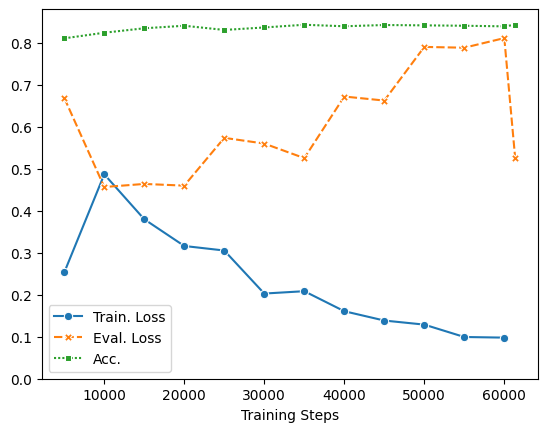

In [75]:
import seaborn as sns

data = training_history[["loss", "eval_mnli_matched_loss", "step", "eval_mnli_matched_accuracy", ]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Steps", "Acc."]
data = data[:-1]  # drop last tow rows, as those rows just contains the values for the best checkpoint again
data = pd.melt(data, ['Training Steps'])


plot = sns.lineplot(data=data, x="Training Steps", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown("### Loss and Evaluation Metrics over Training Steps (matched)"))

### Loss and Evaluation Metrics over Training Steps (mismatched)

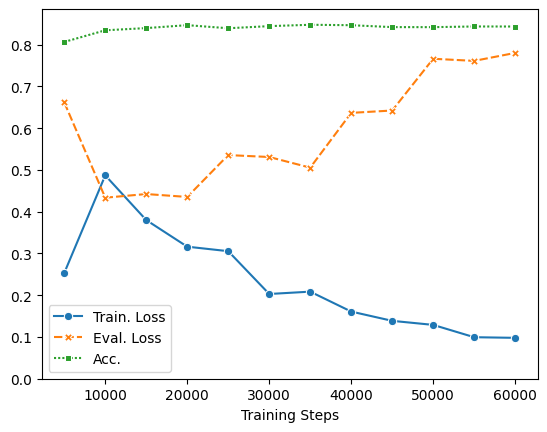

In [76]:
data = training_history[["loss", "eval_mnli_mismatched_loss", "step", "eval_mnli_mismatched_accuracy", ]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Steps", "Acc."]
data = data[:-1]  # drop last tow rows, as those rows just contains the values for the best checkpoint again
data = pd.melt(data, ['Training Steps'])


plot = sns.lineplot(data=data, x="Training Steps", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown("### Loss and Evaluation Metrics over Training Steps (mismatched)"))

In [84]:
results = pd.DataFrame(
    best_model_evaluation.values(),
    index=best_model_evaluation.keys(),
    columns=["Our Model"],
).drop(
    # Drop runtime measurements
    index=[
        "eval_mnli_matched_runtime",
        "eval_mnli_mismatched_runtime",
        "eval_mnli_matched_samples_per_second",
        "eval_mnli_mismatched_samples_per_second",
        "eval_mnli_matched_steps_per_second",
        "eval_mnli_mismatched_steps_per_second",
        "epoch",
    ]
)
results

,Our Model
eval_mnli_matched_loss,0.525529
eval_mnli_matched_accuracy,0.843199
eval_mnli_mismatched_loss,0.505415
eval_mnli_mismatched_accuracy,0.847539
eval_accuracy_avg,0.845369


In [95]:
display(Markdown(f"### Best Model performance:"))
results = pd.DataFrame(
    best_model_evaluation.values(),
    index=best_model_evaluation.keys(),
    columns=["Our Model"],
).drop(
    # Drop runtime measurements
    index=[
        "eval_mnli_matched_runtime",
        "eval_mnli_mismatched_runtime",
        "eval_mnli_matched_samples_per_second",
        "eval_mnli_mismatched_samples_per_second",
        "eval_mnli_matched_steps_per_second",
        "eval_mnli_mismatched_steps_per_second",
        "epoch",
    ]
)
# Achieved scores from original BERT paper:
results["original BERT_BASE"] = ["-", 0.846, "-", 0.834, "-"]
results["original BERT_LARGE"] = ["-", 0.867, "-", 0.859, "-"]
print(
    f'"Our Model" based on {PRE_TRAINED_CHECKPOINT}, best performance on validation data.'
)
print(
    '"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.'
)
results

### Best Model performance:

"Our Model" based on google-bert/bert-base-uncased, best performance on validation data.
"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,Our Model,original BERT_BASE,original BERT_LARGE
eval_mnli_matched_loss,0.525529,-,-
eval_mnli_matched_accuracy,0.843199,0.846,0.867
eval_mnli_mismatched_loss,0.505415,-,-
eval_mnli_mismatched_accuracy,0.847539,0.834,0.859
eval_accuracy_avg,0.845369,-,-
